In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import cv2

We import all the libraries used in this project.

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32 
AUTOTUNE = tf.data.AUTOTUNE
data_dir = Path('New Plant Diseases Dataset(Augmented)')
train_dir = data_dir / 'train'
valid_dir = data_dir / 'valid'
class_names = sorted([item.name for item in train_dir.glob('*') if item.is_dir()])
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names[:5]}")

Number of classes: 38
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']


We use pathlib library to set the path of our data to a variable from which we extract training and testing data. 
We get the list of class name from their folder's name, and print the number of folder. Also to know what the class name seem like we print the first 5 folder's name

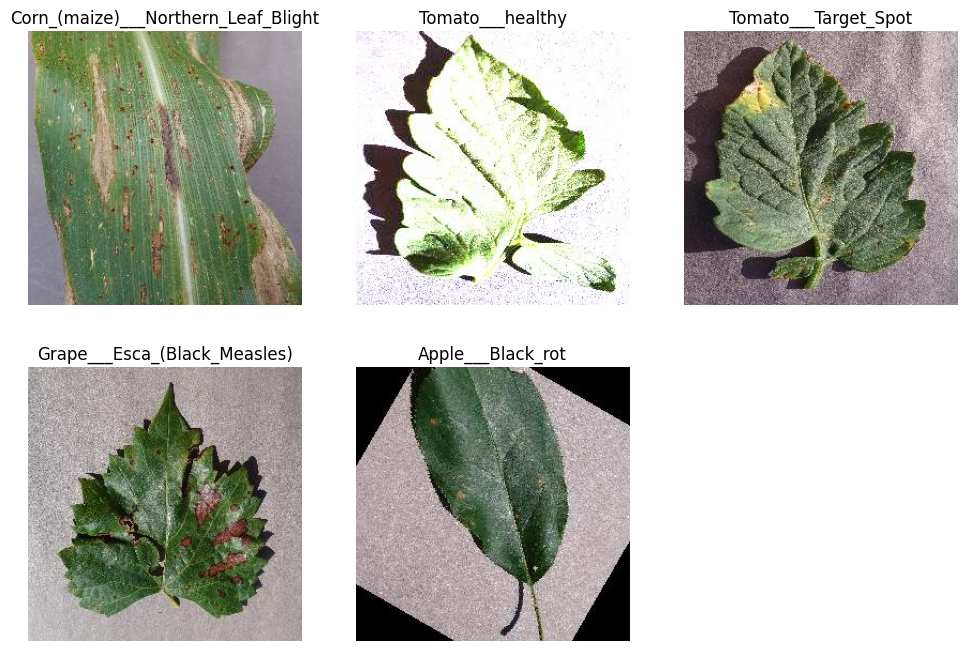

In [6]:
plt.figure(figsize=(12, 8))
for i in range(5):
    random_class = np.random.choice(class_names)
    class_path = train_dir / random_class
    random_image_path = np.random.choice(list(class_path.glob('*.JPG')))
    image = cv2.imread(str(random_image_path))
    image_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, i + 1)
    plt.imshow(image_rgb)
    plt.title(random_class)
    plt.axis('off')

plt.show()

We import an important library know as cv2(Open CV- open source Computer Vision). It helps with image preprocessing, augmentation, and visualization before feeding data into neural networks. We use it to visualise few images which gives us an understanding of the type of images we are working with.

random_image_path = np.random.choice(list(class_path.glob('*.JPG'))) ?????????

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42
)

Found 140590 files belonging to 38 classes.
Found 35144 files belonging to 38 classes.


This is arguably the most important code block in our entire data preparation phase. We are invoking Tensorflow library's function image_dataset_from_directory(). Understanding each argument we pass is crucial for understanding loading, labeling, resizing, batching, and shuffling.
1) train_dr - The path containing training data.
2) labels='inferred' - It looks into the label's of our folder and assigns images in them with folder's name.
3) label_mode='categorical' -This converts each label into a numerical vector by OneHotEncoding. As we have 38 label(folder's) we get a vector or 38 length.
4) image_size=IMG_SIZE - Clear by the name we are storing the size(dimension) of an image, because neural network's takes images of only fixed dimensions.
5) interpolation='nearest' - If images are not of the assigned image_size, they are resized. The nearest is a simple fast algorithm for resizing the image so that it still looks like the original and not distorted.
6) batch_size=BATCH_SIZE - We send images in a group of 32. Sending 70,000 images into RAM for processing is "IMPOSSIBLE", hence we make small batches as this is memory friendly and also helps model learn stably.
7) shuffle=True(training data), shuffle=False(testing data) - It is crucial for shuffling the images for training the model so that it prevents the model from learning unintended patterns based on the order of the data.
8) seed=42 - This is similar to "random_state" attribute we use in most of our machine learning model, if you are unaware please research into it

In [8]:
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


This is to check if our pipeline we built is rightly structured or not. We use a for loop on train_ds. The take(1) function returns a single batch from multiple batches that was created, hence the loop only executes once.
The first print statement print("Image batch shape:", images.shape), images variable holds the data in a format called tensor which is a multi-dimensional array, .shape is an attribute of tensor that tells us its dimension. The output you see (32, 224, 224, 3) means it has 32 images, 224 height, 224 width, 3 colors(RGB).
The next print statement print("Label batch shape:", labels.shape), tells us there are 32 lables each for an image and 38 is our number of classes, which tells us that each label has been successfully converted into a one-hot encoded vector of length 38.

In [ ]:
import tensorflow as tf

# Define the path to your saved model on Google Drive
checkpoint_path = "/content/drive/MyDrive/plant_project_checkpoints/best_model.keras"

# Load the model with its learned weights
model = tf.keras.models.load_model(checkpoint_path)

print("✅ Successfully loaded model from your last best checkpoint!")
model.summary() # Verify the model loaded correctly

Do not run this yet

In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)

x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

This cell contains code to make our pipeline more efficient. The .cache() function - subsequent epochs, the data will be read from your fast RAM instead of the slow hard drive.
prefetch(buffer_size=AUTOTUNE) -  ensures the GPU never has to wait, it keeps the next batch ready until the GPU processes the images.

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "/content/drive/MyDrive/plant_project_checkpoints/best_model.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

EPOCHS = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_callback] 
)

print("\n✅ Initial training complete! The best model has been saved to your Google Drive.")

Epoch 1/15
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.4075 - loss: 2.1778
Epoch 1: val_accuracy improved from -inf to 0.47468, saving model to /content/drive/MyDrive/plant_project_checkpoints/best_model.keras
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 176s 139ms/step - accuracy: 0.4076 - loss: 2.1773 - val_accuracy: 0.4747 - val_loss: 1.7698
Epoch 2/15
1098/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6599 - loss: 1.1413
Epoch 2: val_accuracy improved from 0.47468 to 0.49152, saving model to /content/drive/MyDrive/plant_project_checkpoints/best_model.keras
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 159s 115ms/step - accuracy: 0.6599 - loss: 1.1412 - val_accuracy: 0.4915 - val_loss: 1.7136
Epoch 3/15
1098/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6893 - loss: 1.0198
Epoch 3: val_accuracy improved from 0.49152 to 0.51497, saving model to /content/drive/MyDrive/plant_project_checkpoints/best_model.keras
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 141s 114ms/step - accuracy: 0.6893 - loss: 1

Run the below only to resume the model training if crashed

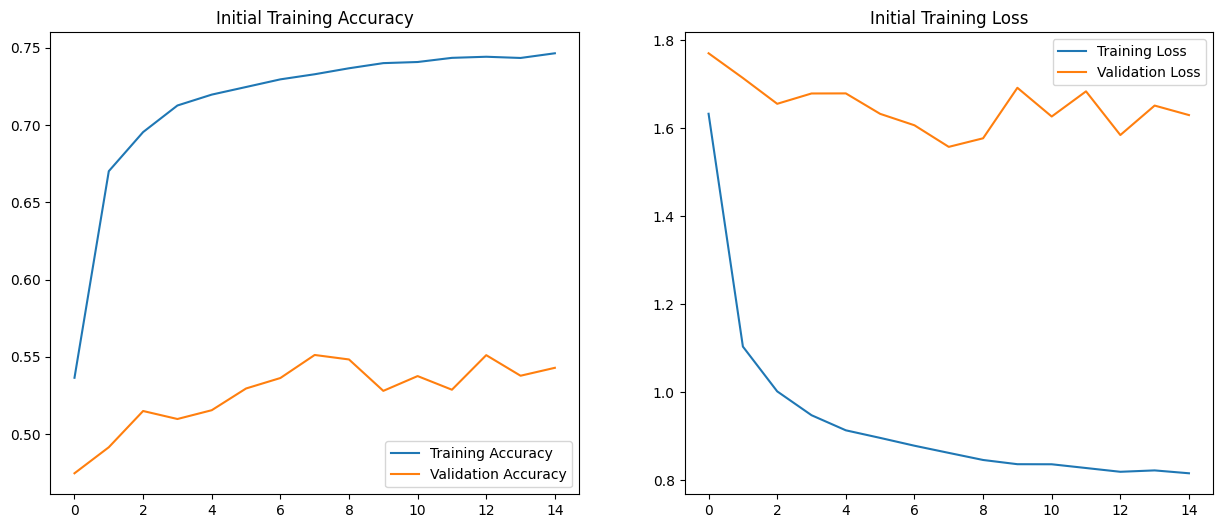

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Initial Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Initial Training Loss')
plt.show()

Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.73      0.27      0.39       504
                                 Apple___Black_rot       0.60      0.60      0.60       497
                          Apple___Cedar_apple_rust       0.89      0.32      0.47       440
                                   Apple___healthy       0.27      0.86      0.41       502
                               Blueberry___healthy       0.59      0.54      0.56       454
          Cherry_(including_sour)___Powdery_mildew       0.98      0.41      0.58       421
                 Cherry_(including_sour)___healthy       0.96      0.59      0.73       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.65      0.61      0.63       410
                       Corn_(maize)___Common_rust_       0.98      0.95      0.96       477
               Corn_(maize)___Northern_Leaf_Blight     

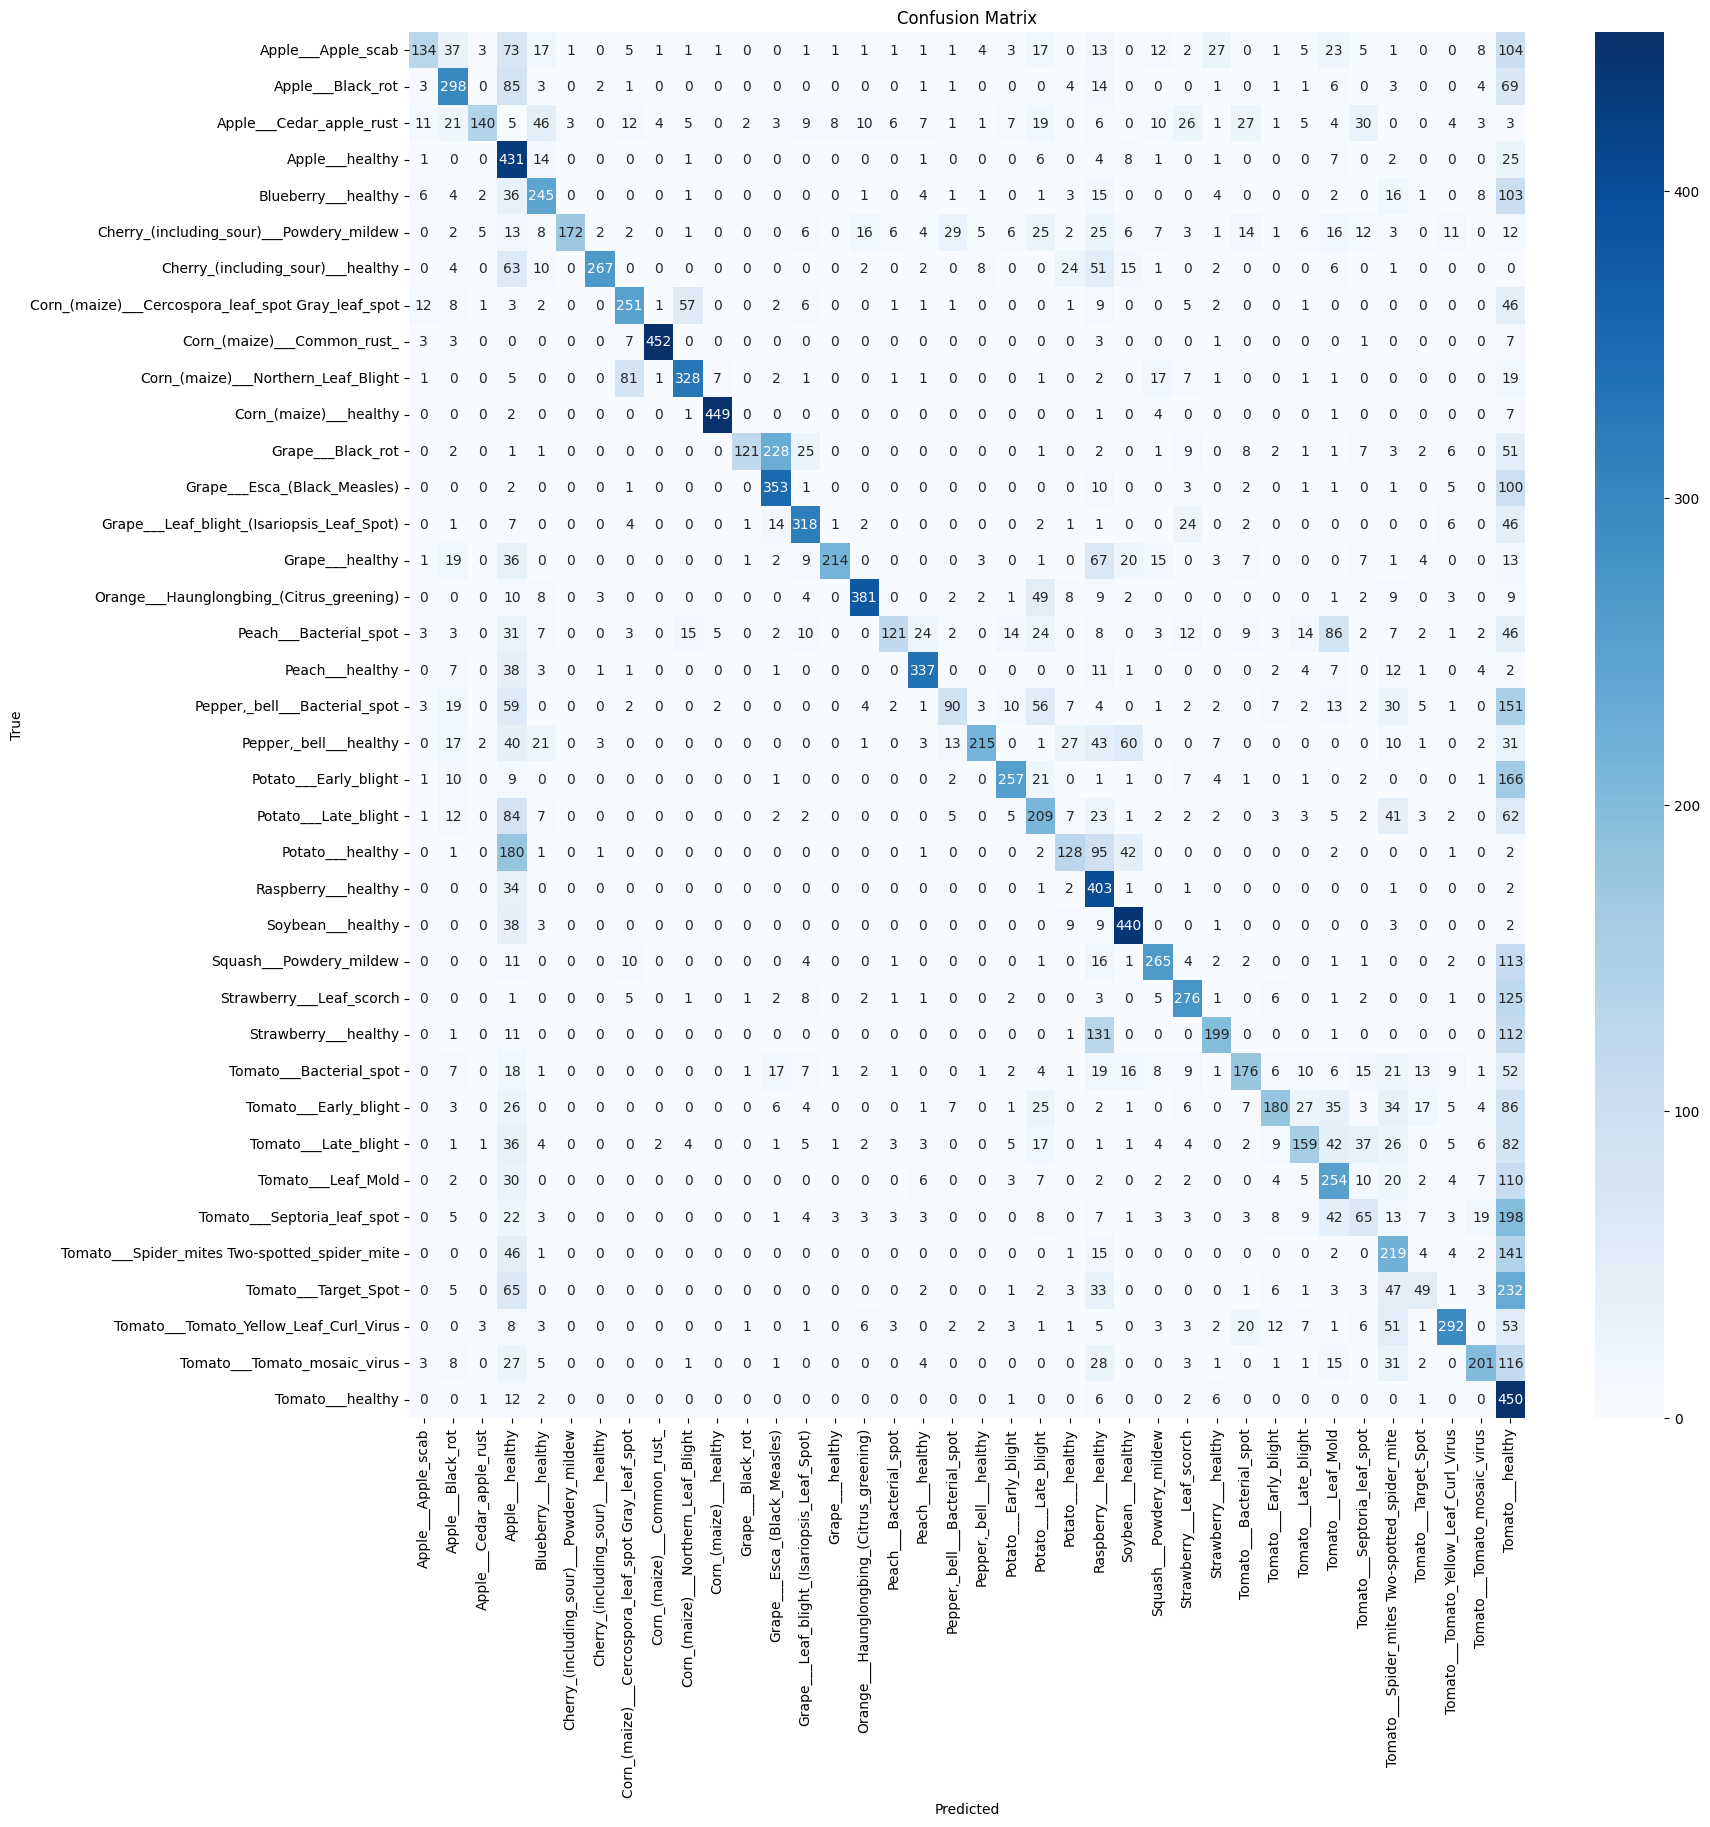

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = []  
y_true = []  

for image_batch, label_batch in val_ds:
   y_true.extend(label_batch.numpy())
   preds = model.predict(image_batch, verbose=0)
   y_pred.extend(np.argmax(preds, axis=-1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))
print("\nConfusion Matrix:\n")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(18, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "/content/drive/MyDrive/plant_project_checkpoints/best_model.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.makedirs(checkpoint_dir, exist_ok=True) 
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)
FINE_TUNE_EPOCHS = 15
total_epochs = EPOCHS + FINE_TUNE_EPOCHS

history_fine_tune = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]+1,
    validation_data=val_ds,
    callbacks=[checkpoint_callback]
)

Epoch 16/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9265 - loss: 0.2188
Epoch 16: val_accuracy improved from -inf to 0.78181, saving model to /content/drive/MyDrive/plant_project_checkpoints/best_model.keras
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 201s 183ms/step - accuracy: 0.9265 - loss: 0.2188 - val_accuracy: 0.7818 - val_loss: 0.8337
Epoch 17/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9378 - loss: 0.1847
Epoch 17: val_accuracy did not improve from 0.78181
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 182s 165ms/step - accuracy: 0.9378 - loss: 0.1847 - val_accuracy: 0.7748 - val_loss: 0.8736
Epoch 18/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9473 - loss: 0.1565
Epoch 18: val_accuracy did not improve from 0.78181
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 220s 182ms/step - accuracy: 0.9473 - loss: 0.1565 - val_accuracy: 0.7078 - val_loss: 1.3160
Epoch 19/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9541 - loss: 0.1337
Epoch 19: val_accuracy did 

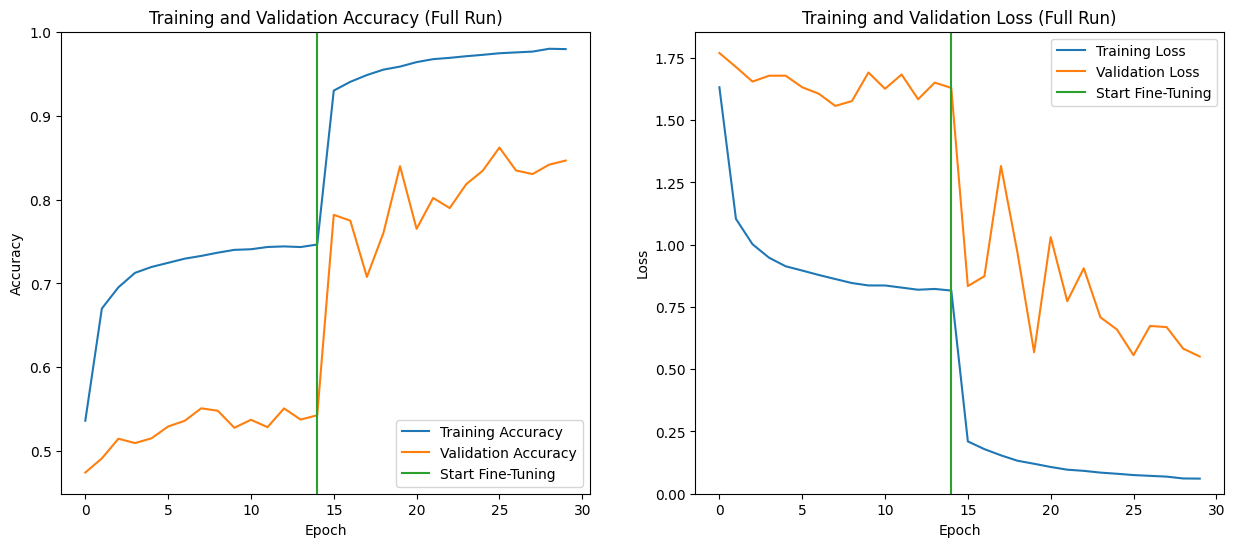

In [24]:
import matplotlib.pyplot as plt
acc = history.history['accuracy'] + history_fine_tune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine_tune.history['val_accuracy']
loss = history.history['loss'] + history_fine_tune.history['loss']
val_loss = history.history['val_loss'] + history_fine_tune.history['val_loss']
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()), 1]) 

plt.plot([EPOCHS-1, EPOCHS-1], plt.ylim(), label='Start Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Full Run)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, max(plt.ylim())]) 
plt.plot([EPOCHS-1, EPOCHS-1], plt.ylim(), label='Start Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Full Run)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Loading the best saved model from Google Drive...
✅ Model loaded successfully!

Generating predictions on the validation dataset...
✅ Predictions generated.

Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.94      0.81      0.87       504
                                 Apple___Black_rot       0.94      0.95      0.95       497
                          Apple___Cedar_apple_rust       0.96      0.88      0.92       440
                                   Apple___healthy       0.76      0.92      0.83       502
                               Blueberry___healthy       0.99      0.83      0.90       454
          Cherry_(including_sour)___Powdery_mildew       0.97      0.83      0.90       421
                 Cherry_(including_sour)___healthy       0.79      0.97      0.87       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.80      0.87

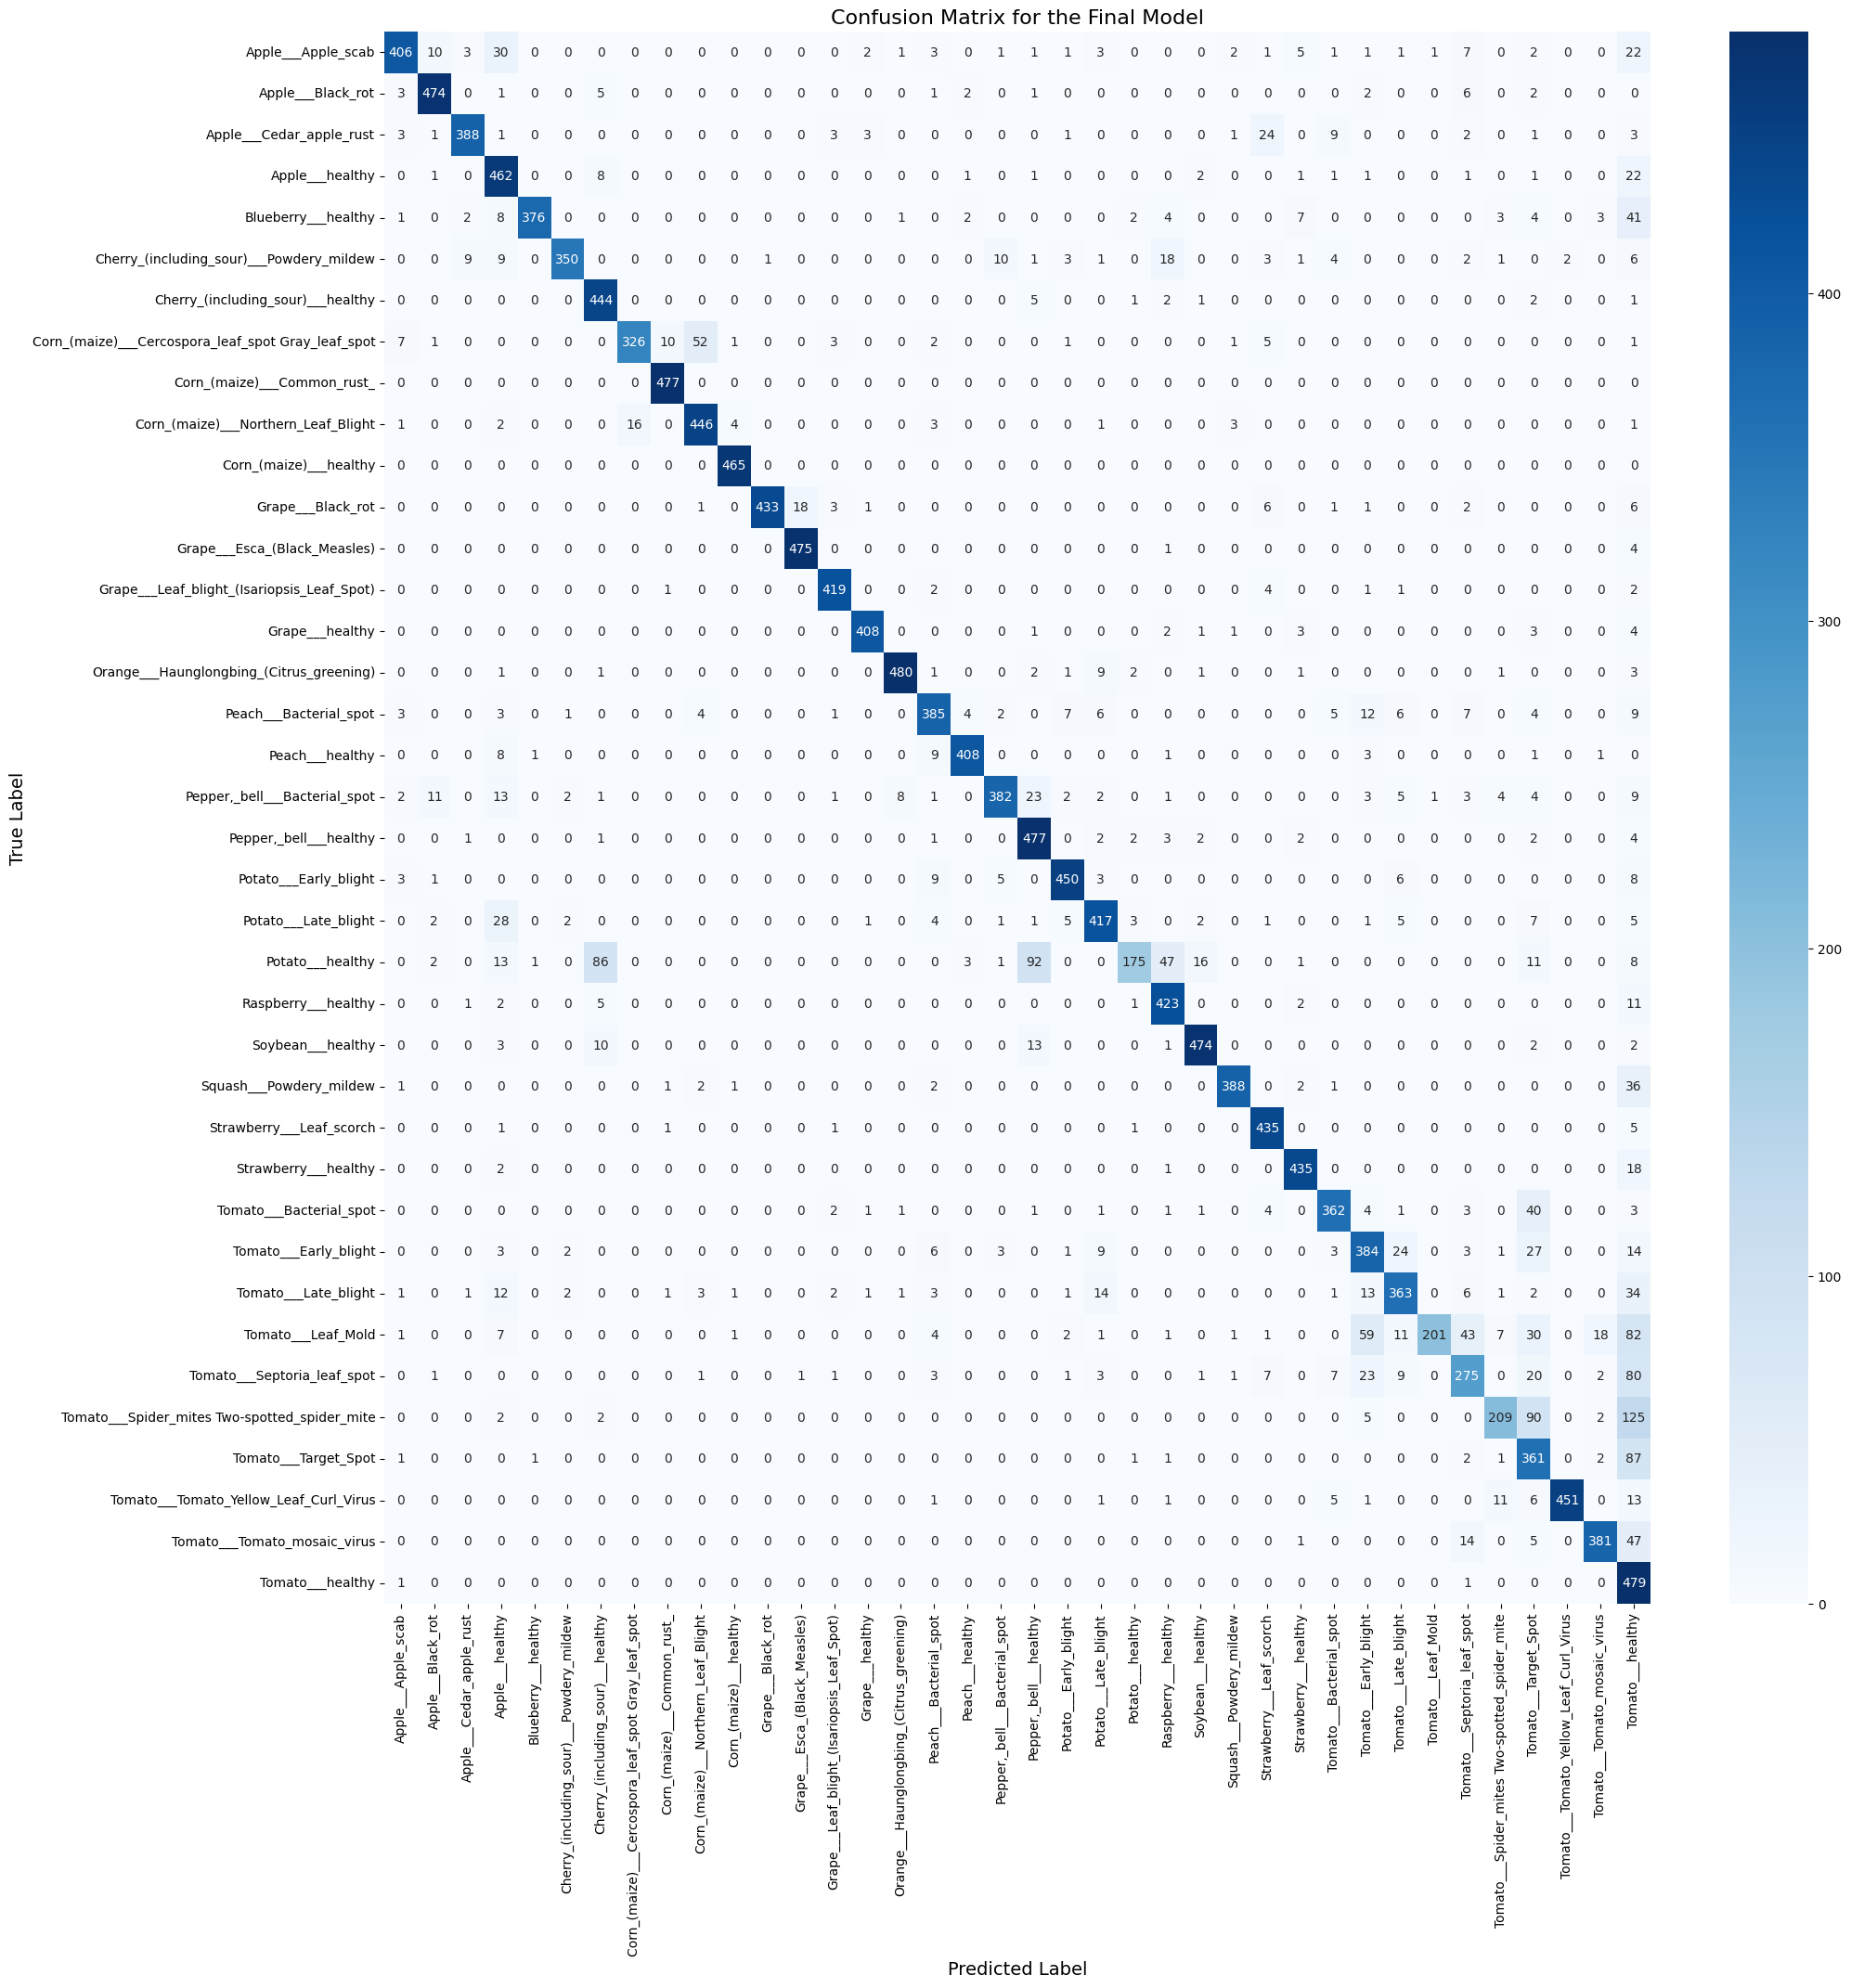

In [27]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Loading the best saved model from Google Drive...")
saved_model_path = "/content/drive/MyDrive/plant_project_checkpoints/best_model.keras"
model = tf.keras.models.load_model(saved_model_path)
print("Model loaded successfully!")

print("\nGenerating predictions on the validation dataset...")
y_pred = []  
y_true = []  

for image_batch, label_batch in val_ds:
   y_true.extend(label_batch.numpy())
   preds = model.predict(image_batch, verbose=0)
   y_pred.extend(np.argmax(preds, axis=-1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\nConfusion Matrix:\n")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(22, 22))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix for the Final Model', fontsize=16)
plt.show()

In [29]:
model.save("plant_disease_model.keras")